In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import json
import os
import nltk
import dateutil
import matplotlib.pyplot as plt
import warnings
import re
import seaborn as sns

from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.corpus import stopwords
from wordcloud import WordCloud

warnings.filterwarnings("ignore", category=DeprecationWarning)
sns.set()

In [2]:
jsondata = './data'
stop_words = set(
    stopwords.words('english') + list(punctuation) + ['AT_USER', 'URL'])

In [3]:
# Merge two json files

tweets = []

for jsfile in os.listdir(jsondata):
    jsfile_path = os.path.join(jsondata, jsfile)
    with open(jsfile_path, 'r') as f:
        tweets_dict = json.load(f)
        tweets.extend(tweets_dict['tweets'])

In [4]:
def get_hashtags(tags_list):
    hashtags = []
    for tag in tags_list:
        hashtags.append(tag['text'])
    return hashtags


def get_tweet_words(tweet):
    """Clean up tweet"""
    
    tweet = tweet.lower()  # convert text to lower-case
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL',
                   tweet)  # remove URLs
    tweet = re.sub('@[^\s]+', 'AT_USER', tweet)  # remove usernames
    tweet = re.sub(r'#([\w]+)', '', tweet)  # remove the # in #hashtag
    tweet = word_tokenize(
        tweet)  # remove repeated characters (helloooooooo into hello)
    return [word for word in tweet if word not in stop_words and len(word) > 3]


def process_tweet(tweet):
    """Process tweets from raw files"""

    tweet_id = tweet['id_str']
    created_time = dateutil.parser.parse(
        tweet['created_at']).replace(tzinfo=None)
    text = tweet['full_text'] if 'full_text' in tweet else tweet['text']
    words = get_tweet_words(text)
    hashtags = get_hashtags(tweet['entities']['hashtags'])
    retweet_count = tweet['retweet_count']
    favorite_count = tweet['favorite_count']
    followers_count = tweet['user']['followers_count']

    return {
        'created_time': created_time,
        'tweet_id': tweet_id,
        'tweet_text': text,
        'tweet_words': words,
        'hashtags': hashtags,
        'retweet_count': retweet_count,
        'favorite_count': favorite_count,
        'followers_count': followers_count
    }


def create_pd_dataset(tweets):
    """Create pandas dataframe of tweet data"""

    records = []
    for tweet in tweets:
        record = process_tweet(tweet)
        records.append(record)

    df = pd.DataFrame(records)
    df.set_index('created_time', inplace=True)
    return df

In [5]:
df = create_pd_dataset(tweets)

In [6]:
df.head()

,tweet_id,tweet_text,tweet_words,hashtags,retweet_count,favorite_count,followers_count
created_time,,,,,,,
2020-05-26 10:55:50,1265235187094433793,Put that mask on. \nLet's save ourselves and t...,"[mask, save, around]",[StaySafeUg],0,0,4354
2020-05-26 10:53:49,1265234680439242752,@KagutaMuseveni has arrived in Mukono for the ...,"[arrived, mukono, launch, lida, packaging, pro...",[VisionUpdates],1,12,639756
2020-05-26 10:48:51,1265233429655891971,Among the things we should avoid even as we be...,"[among, things, avoid, even, begin, accessing,...","[StaySafeUg, MidMorningMagazine]",0,2,87622
2020-05-26 10:31:17,1265229010361028616,All is set for @KagutaMuseveni to launch LIDA ...,"[launch, lida, factory, mukono, factory, makes...",[VisionUpdates],10,33,639756
2020-05-26 10:25:24,1265227531256508417,Schools quietly planning to add face mask fees...,"[schools, quietly, planning, face, mask, fees,...","[backtoschool, lockdown, StaySafeUg]",1,2,1149


### Analysis of hashtags appearing on twitter in the last week.

In [7]:
hash_tags = []
for tag in df['hashtags']:
    hash_tags.extend(tag)

In [8]:
wordcloud = WordCloud(width=800, height=500, random_state=20,
                      max_font_size=110).generate(' '.join(hash_tags))

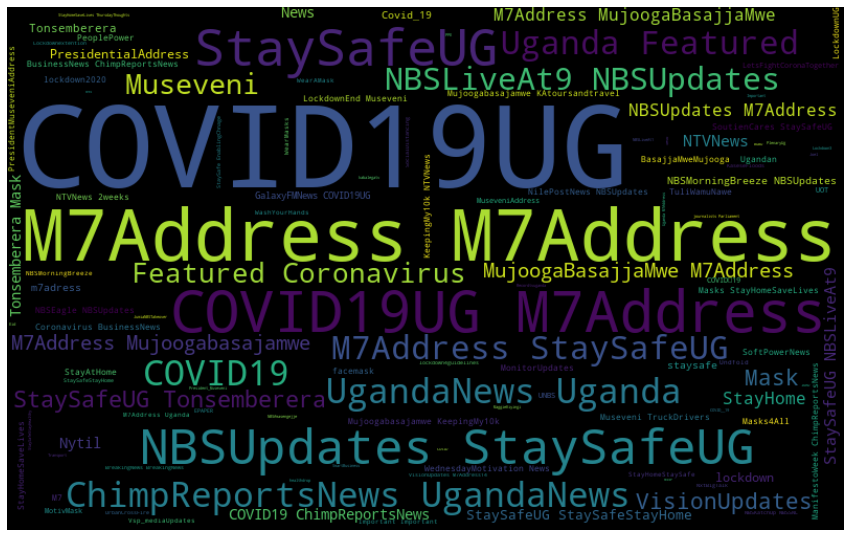

In [9]:
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [10]:
hash_tag_freq = nltk.FreqDist(hash_tags)

In [11]:
hashtag_df = pd.DataFrame({
    'Hashtag': list(hash_tag_freq.keys()),
    'Count': list(hash_tag_freq.values())
})

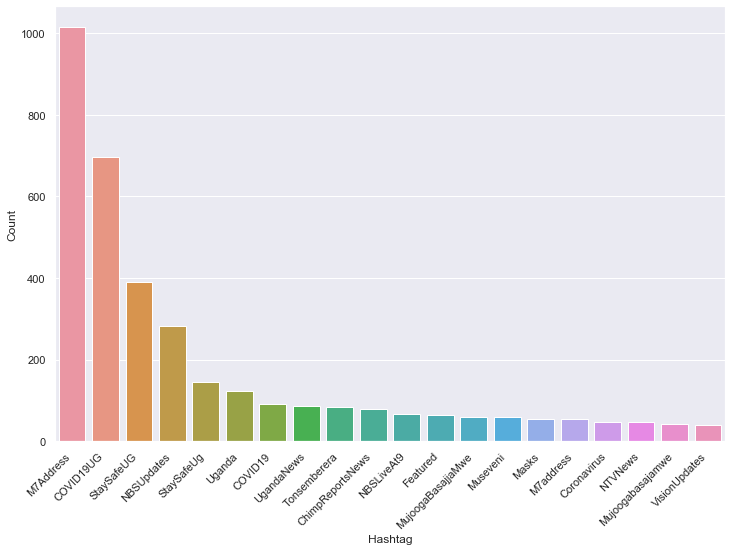

In [12]:
# Get 20 most frequent
ht_data = hashtag_df.nlargest(columns='Count', n=20)

# Barplot
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=ht_data, x="Hashtag", y="Count")
ax.set(ylabel='Count')
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right')
plt.show()

### Analysis of words in tweets

In [13]:
tweet_words = []
for word in df['tweet_words']:
    tweet_words.extend(word)

In [14]:
tweetcloud = WordCloud(width=800,
                       height=500,
                       random_state=20,
                       max_font_size=110).generate(' '.join(tweet_words))

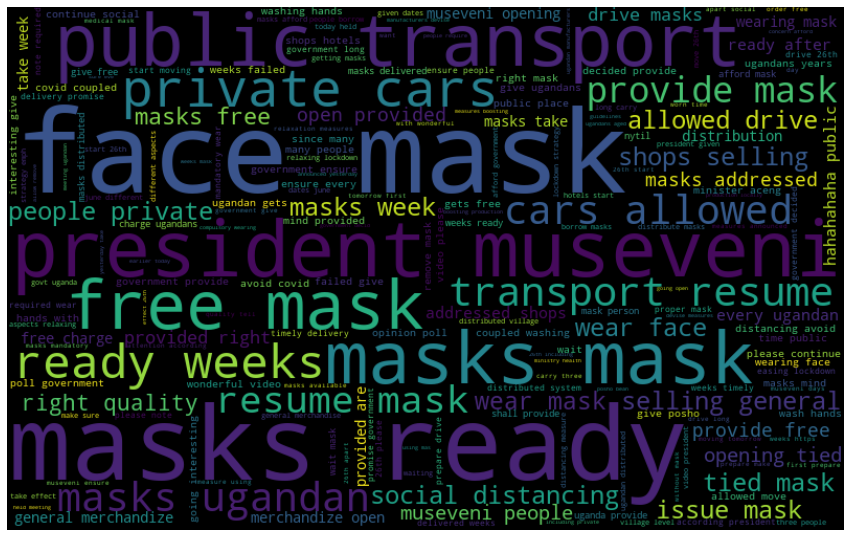

In [15]:
plt.figure(figsize=(15, 10))
plt.imshow(tweetcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [16]:
words_freq = nltk.FreqDist(tweet_words)

In [17]:
tweetwords_df = pd.DataFrame({
    'Tweetword': list(words_freq.keys()),
    'Count': list(words_freq.values())
})

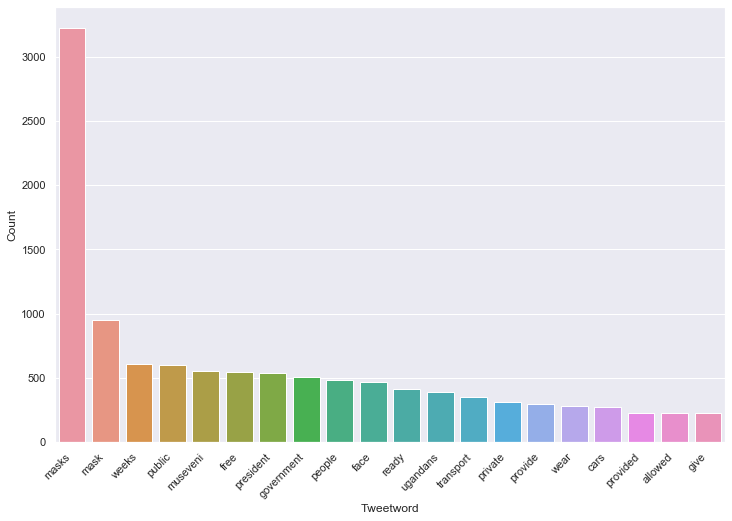

In [18]:
# Get 20 most frequent
words_data = tweetwords_df.nlargest(columns='Count', n=20)

# Barplot
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=words_data, x="Tweetword", y="Count")
ax.set(ylabel='Count')
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right')
plt.show()

### Timeseries of tweets

In [20]:
daily = df['tweet_id'].groupby([df.index.date]).count()

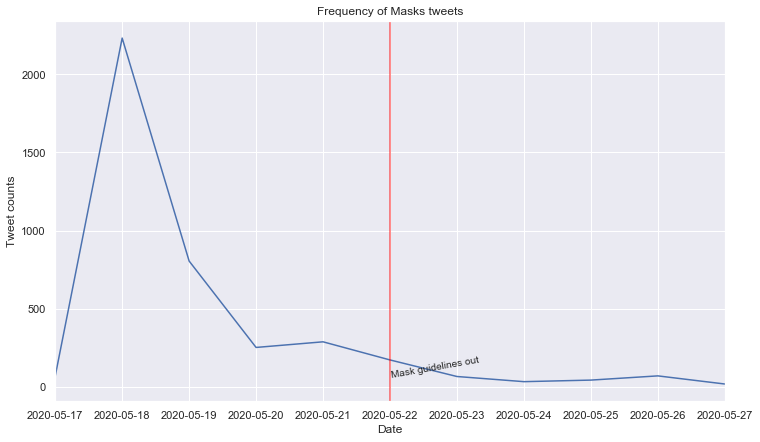

In [22]:
ax = daily.plot(figsize=(12, 7))
mask_guidelines = pd.to_datetime('2020-05-22')
ax.axvline(mask_guidelines, alpha=0.6, color='red')
plt.text(mask_guidelines, 1000, 'Mask guidelines out', rotation=10)

ax.set(title="Frequency of Masks tweets")
ax.set(ylabel="Tweet counts")
ax.set(xlabel="Date")

plt.show()